# Getting Started Keras RNNs

Text data is everywhere and there is plenty of it Therefore it is of no surprise that the analysis of text data has gained popularity in Machine learning. A few applications of machine learning on text data include:

1. Machine translation
2. Sentiment classification
3. Multi-class classification 
4. Text generations (e.g question and answer systems)
5. Entity extraction

Recurrent neural networks (RNNs) have been the popular algorithm to solve these problems.

In this tutorial, we therefore demonstrate how to use an RNN to classify text data. 


## The data set

The data set that we will be looking at is the real or not real twitter data downloaded from [kaggle.](https://www.kaggle.com/c/nlp-getting-started)

This is a binary classification task and we use glove emmeddings

In [0]:
#import all dependencies
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
from google.colab import drive

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU, Dropout, SimpleRNN
from keras.initializers import Constant
import os
import sys

Using TensorFlow backend.


In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/twitterfakenews/train.csv", engine="python", encoding = "latin1", index_col = 'id')
test = pd.read_csv("/content/drive/My Drive/twitterfakenews/test.csv", engine="python", encoding = "latin1")

## High level EDA

In [16]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

The target is an integer, it should be bool 1 or 0. Let us do more EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [0]:
import seaborn as sns

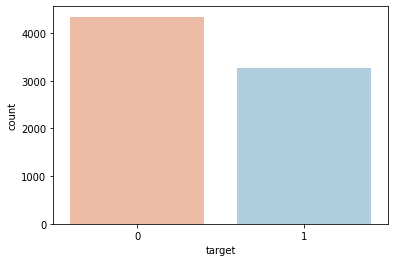

In [11]:
sns.countplot(x = 'target', data = train, palette = 'RdBu') #looks fine

In [0]:
train['target'] = train['target'].astype('bool')

In [0]:
train.drop(["keyword", "location"], axis = 1, inplace = True)
test.drop(["keyword", "location"], axis = 1, inplace = True)

## Cleaning tweets

In [0]:
#clean tweet
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #remove mentions
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [0]:
data_clean = [clean_tweet(tweet) for tweet in train.text]
data_labels = train.target.values #numpy format
test_clean = [clean_tweet(tweet) for tweet in test.text]

In [25]:
#preview
data_clean[0:5]

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 ' people receive wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ']

In [26]:
train.text.head() #the hashtag and numbers have been removed

id
1    Our Deeds are the Reason of this #earthquake M...
4               Forest fire near La Ronge Sask. Canada
5    All residents asked to 'shelter in place' are ...
6    13,000 people receive #wildfires evacuation or...
7    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

## Tokenisation

In [0]:
#creates a tokenizer from training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_clean)

## Text to sequence

In [0]:
#text to sequence
data_clean = tokenizer.texts_to_sequences(data_clean)
test_clean = tokenizer.texts_to_sequences(test_clean)

In [31]:
data_clean[0:2]

[[111, 4371, 21, 1, 840, 5, 18, 248, 130, 1564, 4372, 82, 35],
 [183, 41, 206, 744, 6425, 6426, 1361]]

## Pad sequence

In [0]:
#Make each sentence have equal length
#maximum length of a tweet
sentence_len = 30
#apply
data_clean = pad_sequences(data_clean, maxlen = sentence_len)
test_clean = pad_sequences(test_clean, maxlen = sentence_len)

In [37]:
data_clean[0:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  111, 4371,   21,    1,  840,
           5,   18,  248,  130, 1564, 4372,   82,   35],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  183,   41,  206,  744, 6425, 6426, 1361]], dtype=int32)

In [0]:
#reshape data to three dimensions
data_clean = data_clean.reshape(data_clean.shape[0], 1, data_clean.shape[1])

## Model building

In [0]:
# Build simple RNN model
model = Sequential()
model.add(SimpleRNN(units=128, input_shape=(1, data_clean.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(data_clean,  data_labels, epochs=20, batch_size=32)

Epoch 1/20
7613/7613 [==============================] - 0s 50us/step - loss: 0.6662 - accuracy: 0.5899
Epoch 2/20
7613/7613 [==============================] - 0s 48us/step - loss: 0.6642 - accuracy: 0.5965
Epoch 3/20
7613/7613 [==============================] - 0s 49us/step - loss: 0.6649 - accuracy: 0.5995
Epoch 4/20
7613/7613 [==============================] - 0s 49us/step - loss: 0.6640 - accuracy: 0.5978
Epoch 5/20
7613/7613 [==============================] - 0s 51us/step - loss: 0.6633 - accuracy: 0.6003
Epoch 6/20
7613/7613 [==============================] - 0s 50us/step - loss: 0.6637 - accuracy: 0.5981
Epoch 7/20
7613/7613 [==============================] - 0s 51us/step - loss: 0.6663 - accuracy: 0.5944
Epoch 8/20
7613/7613 [==============================] - 0s 48us/step - loss: 0.6630 - accuracy: 0.5992
Epoch 9/20
7613/7613 [==============================] - 0s 49us/step - loss: 0.6628 - accuracy: 0.5941
Epoch 10/20
7613/7613 [==============================] - 0s 49us/step - l

#Make predictions


In [0]:
#reshape data to three dimensions
test_clean = test_clean.reshape(test_clean.shape[0], 1, test_clean.shape[1])

In [0]:
pred_probabilities = model.predict(test_clean)

In [46]:
pred_probabilities

array([[0.41070446],
       [0.47337937],
       [0.4949292 ],
       ...,
       [0.31551147],
       [0.38053066],
       [0.41238886]], dtype=float32)

In [0]:
#convert probabilities to 1 and 0
y_pred = np.matrix( pred_probabilities)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [0]:
#save predictions
pred = pd.DataFrame(y_pred)
ids = pd.DataFrame(test[['id']])
df = pd.concat([ids, pred], axis = 1)
df.columns = ['id', 'target']
df.set_index('id', inplace=True)

In [49]:
df.head()

,target
id,
0,0.0
2,0.0
3,0.0
9,0.0
11,0.0


In [0]:
#save
df.to_csv("/content/drive/My Drive/twitterfakenews/submission_three.csv")

In [0]:
#submit to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission_three.csv -m "2ndsubmission"